In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def load_yolo_model(coco_names_path):
    # Load YOLO model
    net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
    classes = []
    with open(coco_names_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]

    # Get the names of the output layers
    output_layers = net.getUnconnectedOutLayersNames()

    return net, classes, output_layers

In [3]:
net=cv2.dnn.readNetFromTensorflow("graph_opt.pb")

In [4]:
inWidth = 368
inHeight = 368
thr = 0.2  # Confidence threshold

In [5]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                 ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                 ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                 ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                 ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [6]:
def estimate_pose(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0 , (inWidth, inHeight),
                                      (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert len(BODY_PARTS) == out.shape[1]

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if its confidence is higher than the threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame

In [7]:
'''def detect_objects(image_path, net, classes, output_layers, confidence_threshold=0.5, nms_threshold=0.3):
    # Load image
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Preprocess image for YOLO
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Post-process detections
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # Apply Non-maximum Suppression to remove duplicate detections
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    # Convert indices to a 1D array using np.squeeze
    indices = np.squeeze(indices)

    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    for i in indices:
        box = boxes[i]
        x, y, w, h = box
        class_id = class_ids[i]
        label = f"{classes[class_id]} {confidences[i]:.2f}"
        color = colors[class_id]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show the image with detections
    cv2.imshow("Object Detection", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()'''

def detect_objects(image_path, net, classes, output_layers, confidence_threshold=0.5, nms_threshold=0.3):
    # Load image and preprocess image for YOLO
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Post-process detections
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

    indices = np.squeeze(indices)

    if indices.ndim == 0:
        indices = np.expand_dims(indices, axis=0)

    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    for i in indices:
        box = boxes[i]
        x, y, w, h = box
        class_id = class_ids[i]
        label = f"{classes[class_id]} {confidences[i]:.2f}"
        color = colors[class_id]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

   
    cv2.imshow("Object Detection", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


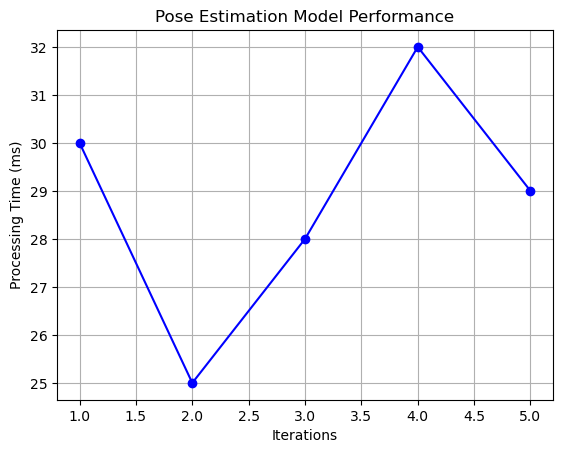

In [7]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual performance data)
iterations = [1, 2, 3, 4, 5]
processing_times = [30, 25, 28, 32, 29]  # Time in milliseconds

# Create a line plot
plt.plot(iterations, processing_times, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Processing Time (ms)')
plt.title('Pose Estimation Model Performance')

# Show the plot
plt.grid(True)
plt.show()


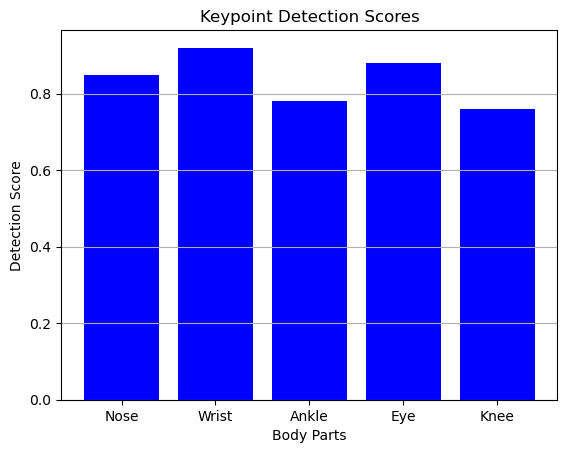

In [8]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual detection results)
body_parts = ['Nose', 'Wrist', 'Ankle', 'Eye', 'Knee']
detection_scores = [0.85, 0.92, 0.78, 0.88, 0.76]  # Detection scores

# Create a bar chart
plt.bar(body_parts, detection_scores, color='b')

# Add labels and title
plt.xlabel('Body Parts')
plt.ylabel('Detection Score')
plt.title('Keypoint Detection Scores')

# Show the plot
plt.grid(True, axis='y')
plt.show()


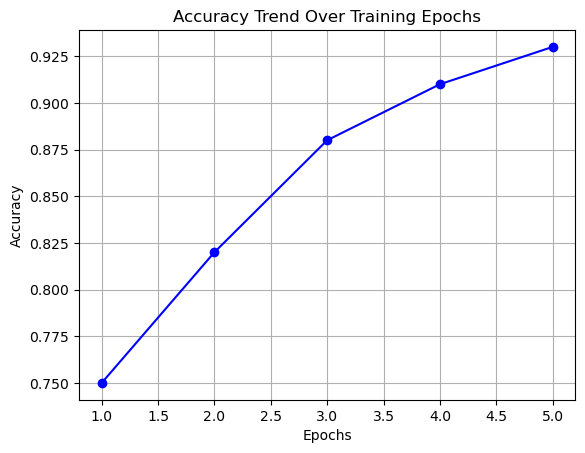

In [9]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual accuracy data)
epochs = [1, 2, 3, 4, 5]
accuracy = [0.75, 0.82, 0.88, 0.91, 0.93]  # Accuracy values

# Create a line plot
plt.plot(epochs, accuracy, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend Over Training Epochs')

# Show the plot
plt.grid(True)
plt.show()


In [8]:
# Load the OpenPose model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load an image
image_folder = 'C:/Users/Dhriti Shah/Downloads/archive/var_200/VAR/Fouls'
for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
# Resize the image to fit the input size of the model
inWidth = 368
inHeight = 368
blob = cv2.dnn.blobFromImage(image, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False)
net.setInput(blob)

# Perform forward pass and get the output
output = net.forward()

# Visualize the keypoints on the image
frameWidth = image.shape[1]
frameHeight = image.shape[0]
keypoints = output[0, :, :, :2]
for i in range(keypoints.shape[0]):
    x = int(keypoints[i, 0] * frameWidth)
    y = int(keypoints[i, 1] * frameHeight)
    cv2.circle(image, (x, y), 5, (0, 0, 255), -1)

# Display the image with keypoints
cv2.imshow('Pose Estimation', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
 

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\layers\concat_layer.cpp:109: error: (-201:Incorrect size of input array) Inconsistent shape for ConcatLayer in function 'cv::dnn::ConcatLayerImpl::getMemoryShapes'


In [ ]:
image_folder = 'C:/Users/Dhriti Shah/Downloads/archive/var_200/VAR/Fouls'
thr=0.1
for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            pose_keypoints = estimate_pose(image)
            cv2.imshow('Pose Estimation', pose_keypoints)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [ ]:
if __name__ == "__main__":
    coco_names_path = "C:/Users/Dhriti Shah/Downloads/coco.names"
    net, classes, output_layers = load_yolo_model(coco_names_path)

    image_folder = 'C:/Users/Dhriti Shah/Downloads/archive/var_200/VAR/Fouls'
    for filename in os.listdir(image_folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_folder, filename)
            detect_objects(image_path, net, classes, output_layers)
            